# Import

In [18]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from time import sleep
import os

In [2]:
df1 = pd.read_csv("../games_metadata_profile.csv")
df2 = pd.read_csv("../games_metadata_profile_2024_01.csv")

df = pd.concat([df1, df2], ignore_index=True)

In [3]:
def format_game_mode(x):
    if "Classical" in x:
        return "Classical game"
    elif "Bullet" in x:
        return "Bullet game"
    elif "Blitz" in x:
        return "Blitz game"
    elif "UltraBullet" in x:
        return "UltraBullet game"
    elif "Rapid" in x:
        return "Rapid game"
    elif "Correspondence" in x:
        return "Correspondence game"
    else:
        return x


df["Mode"] = df["Event"].apply(format_game_mode)

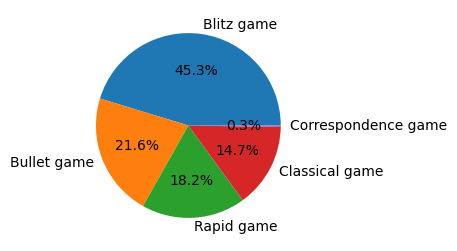

In [6]:
# plot proportion of games by mode
fig, ax = plt.subplots()
df["Mode"].value_counts().plot(kind="pie", autopct="%1.1f%%", ax=ax)
ax.set_ylabel("")
# resize the figure
fig.set_size_inches(3,3)
plt.show()

In [8]:
# filter blitz games
df = df[df["Mode"] == "Blitz game"]

df.shape

(93958, 34)

<Axes: >

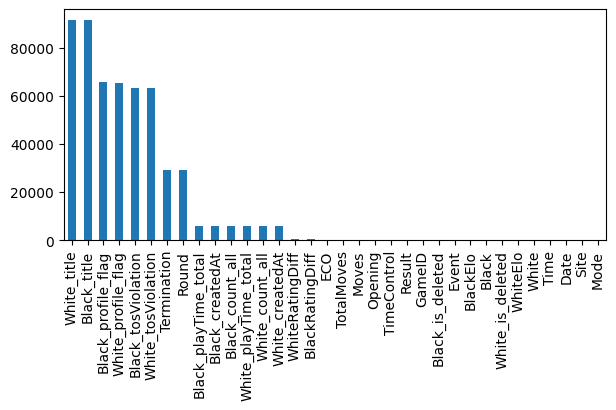

In [10]:
df.isnull().sum().sort_values(ascending=False).plot(kind="bar", figsize=(7,3))

# Move suggestions


In [11]:
import chess
import chess.pgn
from chess.pgn import BaseVisitor
import io


class Visitor(BaseVisitor):
    def __init__(self):
        self.comments = []
        self.moves = []

    def visit_comment(self, comment: str) -> None:
        self.comments.append(comment)

    def visit_move(self, board: chess.Board, move: chess.Move) -> None:
        self.moves.append(move)

    def result(self):
        return self.moves, self.comments

In [19]:
from tqdm import tqdm
import pickle


def get_move_dict(game_df: pd.DataFrame, save_path=None):
    if save_path is not None:
        if save_path.endswith(".pkl") and os.path.exists(save_path):
            with open(save_path, "rb") as f:
                return pickle.load(f)
        else:
            print(f"File {save_path} not found. Generating new move_dict...")

    move_dict = dict()

    assert "Moves" in game_df.columns, "Moves column not found in DataFrame"
    assert "Result" in game_df.columns, "Result column not found in DataFrame"

    for _, row in tqdm(game_df.iterrows(), total=len(game_df)):
        board = chess.Board()
        moves, _ = chess.pgn.read_game(io.StringIO(row["Moves"]), Visitor=Visitor)
        result = row["Result"]

        for move in moves:
            board_code = " ".join(board.fen().split(" ")[:2])
            move_code = move.uci()

            if board_code not in move_dict:
                move_dict[board_code] = {}

            if move_code not in move_dict[board_code]:
                move_dict[board_code][move_code] = [0, 0, 0]  # count, win, lose

            move_dict[board_code][move_code][0] += 1

            if result == "1-0":
                if board.turn == chess.WHITE:
                    move_dict[board_code][move_code][1] += 1
                else:
                    move_dict[board_code][move_code][2] += 1
            elif result == "0-1":
                if board.turn == chess.BLACK:
                    move_dict[board_code][move_code][1] += 1
                else:
                    move_dict[board_code][move_code][2] += 1
            board.push(move)

    if save_path is not None:
        with open(save_path, "wb") as f:
            pickle.dump(move_dict, f)
    return move_dict

In [20]:
def suggest_move(board: chess.Board, move_dict: dict):
    board_code = " ".join(board.fen().split(" ")[:2])

    if board_code not in move_dict:
        return None  # no data for this board

    ranked_moves = sorted(  # sort by count
        move_dict[board_code].items(), key=lambda x: x[1][0], reverse=True
    )

    for move_code, (count, win, lose) in ranked_moves:
        move = chess.Move.from_uci(move_code)
        if move in board.legal_moves:
            return move, (count, win, lose)

    return None  # no legal move found

In [21]:
# board = chess.Board()

# while not board.is_game_over():
#     move_data = suggest_move(board, move_dict)
#     if move_data is None:
#         print("No move found")
#         break

#     move, (count, win, lose) = move_data
#     board.push(move)
#     clear_output(wait=True)
#     print(f"Move: {move.uci()} Win rate: {win / count:.3f}")
#     display(chess.svg.board(board=board, size=400))
#     sleep(0.7)

# Segment game by player's elo

In [22]:
# x <= 1450: beginner
# 1450 < x <= 1800: intermediate
# x > 1800: advanced

df_elo_below_1450 = df[(df["WhiteElo"] + df["BlackElo"]) / 2 <= 1450]
df_elo_1450_to_1800 = df[
    ((df["WhiteElo"] + df["BlackElo"]) / 2 > 1450)
    & ((df["WhiteElo"] + df["BlackElo"]) / 2 <= 1800)
]
df_elo_above_1800 = df[(df["WhiteElo"] + df["BlackElo"]) / 2 > 1800]

print(f"# games with average elo below 1450: {df_elo_below_1450.shape}")

print(f"# games with average elo between 1450 and 1800: {df_elo_1450_to_1800.shape}")

print(f"# games with average elo above 1800: {df_elo_above_1800.shape}")

# games with average elo below 1450: (30057, 34)
# games with average elo between 1450 and 1800: (32038, 34)
# games with average elo above 1800: (31863, 34)


In [23]:
cutoff = 15000  # number of games to use for each partition

df_elo_below_1450 = df_elo_below_1450.sample(cutoff)

df_elo_1450_to_1800 = df_elo_1450_to_1800.sample(cutoff)

df_elo_above_1800 = df_elo_above_1800.sample(cutoff)

print(f"# games with average elo below 1450: {df_elo_below_1450.shape}")

print(f"# games with average elo between 1450 and 1800: {df_elo_1450_to_1800.shape}")

print(f"# games with average elo above 1800: {df_elo_above_1800.shape}")

# games with average elo below 1450: (15000, 34)
# games with average elo between 1450 and 1800: (15000, 34)
# games with average elo above 1800: (15000, 34)


## Generate move dictionary by player's level

In [24]:
move_dict_below_1450 = get_move_dict(
    df_elo_below_1450,
    save_path="data/move_dict_below_1450_15kCUTOFF.pkl",
)

move_dict_1450_to_1800 = get_move_dict(
    df_elo_1450_to_1800,
    save_path="data/move_dict_1450_to_1800_15kCUTOFF.pkl",
)

move_dict_above_1800 = get_move_dict(
    df_elo_above_1800, save_path="data/move_dict_above_1800_15kCUTOFF.pkl"
)

File move_dict_below_1450_15kCUTOFF.pkl not found. Generating new move_dict...


100%|██████████| 15000/15000 [00:56<00:00, 267.61it/s]


File move_dict_1450_to_1800_15kCUTOFF.pkl not found. Generating new move_dict...


100%|██████████| 15000/15000 [00:55<00:00, 269.46it/s]


File move_dict_above_1800_15kCUTOFF.pkl not found. Generating new move_dict...


100%|██████████| 15000/15000 [01:00<00:00, 248.43it/s]


In [29]:
def play_game(
    board: chess.Board, black_policy: dict, white_policy: dict, visualize=False
):

    while not board.is_game_over():
        if board.turn == chess.WHITE:
            move_data = suggest_move(board, white_policy)
        else:
            move_data = suggest_move(board, black_policy)

        if move_data is None:
            print("No move found")
            break

        move, _ = move_data
        board.push(move)

        if visualize:
            clear_output(wait=True)
            print(f"Ply: {board.fullmove_number}")
            display(chess.svg.board(board=board, size=300))
            sleep(1)

    return board.result()

In [33]:
play_game(chess.Board(), move_dict_below_1450, move_dict_above_1800, visualize=True)

No move found


'*'

## Summary

**Target**:
At each level of player, generate a dictionary of moves(a policy) that are most likely to be played by the player at a given board.
Policy of higher level player should be more proficient than lower level player.

- Input: A list of games with player's elo.
- Output: A dictionary of moves for each level of player.

**Problem**: Some board settings are not exist in the dataset, resulting in missing moves in the dictionary, cannot find the next move for the player.

**Idea**:

- Represent the board by a list of important features, not the exact whole board setting ==> Reduce the number of possible board settings. e.g. nearly similar boards may have the same representation.

- Learning a function to predict the next move based on the board representation. The board may not exactly exist in the dataset.
